In [1]:
import shapefile
import math
import json
import random
import shapely
import descartes
import tripy
import matplotlib.pyplot as plt
import alphashape as aps
import trimesh
from perlin_noise import PerlinNoise


sf = shapefile.Reader("./WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp")
shapeRecordNL = [sr for sr in sf.shapeRecords() if 'Netherlands' in sr.record[4]][-1]

In [27]:
points = shapeRecordNL.shape.points
parts = shapeRecordNL.shape.parts
n_parts = len(parts)
# draw center of bounding box in middle
x_norm = (shapeRecordNL.shape.bbox[0] + shapeRecordNL.shape.bbox[2]) / 2
z_norm = (shapeRecordNL.shape.bbox[1] + shapeRecordNL.shape.bbox[3]) / 2
bbox_normalized = [
    (shapeRecordNL.shape.bbox[0] - x_norm),
    (shapeRecordNL.shape.bbox[1] - z_norm),
    (shapeRecordNL.shape.bbox[2] - x_norm),
    (shapeRecordNL.shape.bbox[3] - z_norm),
]

n_points = len(points)
angle = 0  # fl
flip = -1  # the -1 is to flip the image on the north axis, it's more natural for three js


def rotate(point, angle):
    ox, oy = (0.0, 0.0)
    px, py = point
    cos = math.cos(angle)
    sin = math.sin(angle)
    qx = ox + cos * (px - ox) - sin * (py - oy)
    qy = oy + sin * (px - ox) + cos * (py - oy)
    return qx, qy

def rotate2(point, angle):
    ox, oy = (0.0, 0.0)
    px, py = point[0], point[2]
    px = (px - x_norm) * flip
    py = (py - z_norm) * flip
    cos = math.cos(angle)
    sin = math.sin(angle)
    qx = ox + cos * (px - ox) - sin * (py - oy)
    qy = oy + sin * (px - ox) + cos * (py - oy)
    return qx, point[1], qy, point[3], point[4]



# points = [rotate(((p[0] - x_norm) * flip, (p[1] - z_norm) * flip), math.radians(angle)) for p in points]

polygons = []
for i in range(len(parts)):
    start = parts[i]
    end = parts[i + 1] if i != (len(parts) - 1) else None
    polygon = shapely.geometry.Polygon(shapely.geometry.LinearRing(points[start:end]))
    polygons.append(polygon)

columns = 256
rows = 256
column_delta_unnormalized = (shapeRecordNL.shape.bbox[2] - shapeRecordNL.shape.bbox[0]) / columns
row_delta_unnormalized = (shapeRecordNL.shape.bbox[3] - shapeRecordNL.shape.bbox[1]) / rows
is_contained = lambda point: any([p.contains(shapely.geometry.Point(point)) for p in polygons])
noise = PerlinNoise(octaves=1)
grid_points = [((shapeRecordNL.shape.bbox[0] + (x * column_delta_unnormalized)), abs(noise([x * column_delta_unnormalized, z * row_delta_unnormalized])), (shapeRecordNL.shape.bbox[1] + (z * row_delta_unnormalized)), (x), (z)) for x in
               range(columns) for z in range(rows)]
# column_delta = (bbox_normalized[2] - bbox_normalized[0]) / columns
# row_delta = (bbox_normalized[3] - bbox_normalized[1]) / rows
grid_points = [(point[0], point[1], point[2], point[3], point[4]) for point in grid_points if is_contained((point[0], point[2]))]
grid_points = [rotate2(p, math.radians(angle)) for p in grid_points]

# todo could only calc noise for points actually contained dunno how long this takes

[[<matplotlib.lines.Line2D at 0x16e84f340>],

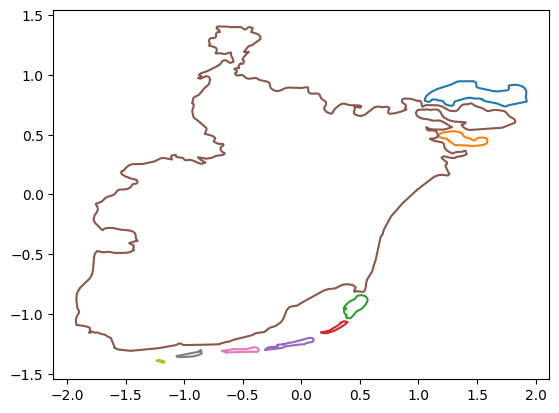

In [28]:
points = [rotate(((p[0] - x_norm) * flip, (p[1] - z_norm) * flip), math.radians(angle)) for p in points]

polygons = []
for i in range(len(parts)):
    start = parts[i]
    end = parts[i + 1] if i != (len(parts) - 1) else None
    polygon = shapely.geometry.Polygon(shapely.geometry.LinearRing(points[start:end]))
    polygons.append(polygon)
[plt.plot(*polygon.exterior.xy) for polygon in polygons]

In [37]:
polygons[0].exterior.xy[:10]

(array('d', [1.5397374346349428, 1.5184158201339946, 1.4780512366752836, 1.4399652987595308, 1.4157953766553382, 1.318139127019136, 1.3047113927166114, 1.299340298815749, 1.2898188147864706, 1.26825305953109, 1.244896940241616, 1.230492642921134, 1.2239008461471448, 1.2126703768364413, 1.2037999345193802, 1.1926508457599274, 1.1684809236557347, 1.1584711581174778, 1.1520421215466703, 1.1174555329464928, 1.1002843103726567, 1.0939366525545173, 1.074405402986982, 1.0524688320709705, 1.0529987396001692, 1.0604401456961758, 1.0660211998185636, 1.1053986415341077, 1.155008015507561, 1.2789281012509113, 1.324506714713137, 1.3469342857886621, 1.465273315611042, 1.477675660003725, 1.4925584721957383, 1.494212117695084, 1.4925584721957383, 1.4977261151681054, 1.5166396896699856, 1.6389061281153507, 1.6644342855138765, 1.6891356206124177, 1.7289264743773023, 1.7449461672318725, 1.759622274748195, 1.7705776783172231, 1.7724380284922594, 1.7698542079053672, 1.7727480877540946, 1.8200836995031713, 

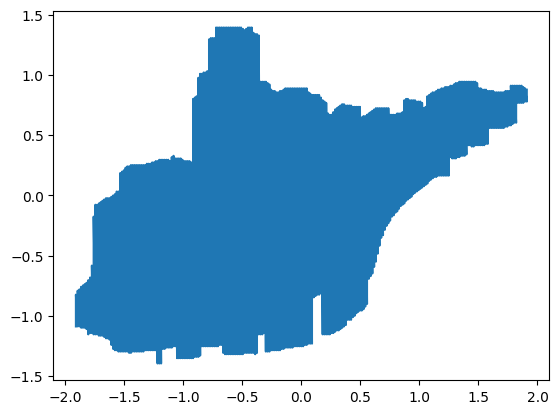

In [38]:
plt.plot([point[0] for point in grid_points], [point[2] for point in grid_points])

In [39]:
half_column_delta = column_delta / 2
half_row_delta = row_delta / 2

def create_cube(point):
    x_start = point[0] - half_column_delta
    y_start = 0.001
    z_start = point[2] - half_row_delta
    x_end = point[0] + half_column_delta
    y_end = point[1]
    z_end = point[2] + half_row_delta

    p1 = [
        x_start, y_start, z_start
    ]
    p2 = [
        x_start, y_start, z_end
    ]
    p3 = [
        x_start, y_end, z_start
    ]
    p4 = [
        x_end, y_start, z_start
    ]
    p5 = [
        x_start, y_end, z_end
    ]
    p6 = [
        x_end, y_end, z_start
    ]
    p7 = [
        x_end, y_start, z_end
    ]
    p8 = [
        x_end, y_end, z_end
    ]

    t1 = [
        p1, p4, p6
    ]
    t2 = [
        p1, p3, p6
    ]

    t3 = [
        p1, p2, p5
    ]
    t4 = [
        p1, p3, p5
    ]

    t5 = [  # these are the bottom triangles most likely
        p1, p4, p7
    ]
    t6 = [  # these are the bottom triangles most likely
        p1, p2, p7
    ]

    t7 = [
        p8, p2, p7
    ]

    t8 = [
        p8, p5, p2
    ]

    t9 = [
        p8, p6, p3
    ]

    t10 = [
        p8, p5, p3
    ]

    t11 = [
        p8, p7, p4
    ]

    t12 = [
        p8, p6, p4
    ]
    positions = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12]
    positions = [item for sublist in positions for item in sublist]
    positions = [item for sublist in positions for item in sublist]
    return positions
cubes_flat = [item for sublist in [create_cube(point) for point in points] for item in sublist]

IndexError: tuple index out of range

In [40]:
import utils
ids = []
max_vertices = 0
min_x = 0
min_z = 0
max_x = 0
max_z = 0
for i, point in enumerate(grid_points):
    cubes_flat = create_cube(point)
    xs = cubes_flat[0::3]
    zs = cubes_flat[2::3]
    min_x = min(min_x, *xs)
    min_z = min(min_z, *zs)
    max_x = max(max_x, *xs)
    max_z = max(max_z, *zs)
    max_vertices = max(max_vertices, len(cubes_flat))
    level = 0
    column = point[3]
    row = point[4]
    id = f"{(column * rows) + row}"
    ids.append(id)
    path = f'../frontend/public/chunks/{id}_{level}.json'
    utils.store_as_json(cubes_flat, path)
    # print("wrote cubes")


if max_vertices % 9 != 0: raise ValueError("should be divisible")

metadata = {
    "chunkIds": ids,
    "levels": [0],
    "maxTriangles": max_vertices / 9,
    "minX": min_x,
    "minZ": min_z,
    "maxX": max_x,
    "maxZ": max_z,
    "columns": columns,
    "rows": rows,
}

with open(f'../frontend/src/chunks/_metadata.json', 'w') as fp:
    json.dump(metadata, fp)

In [ ]:
# points_per_part = []
# for i in range(len(parts)):
#     start = parts[i]
#     end = parts[i+1] if i != (len(parts) - 1) else None
#     points_per_part.append(points[start:end])
#
# def shapely_coords_to_flattened_positions(coords):
#     triangles_3d = [
#         (triangle[0], 0, triangle[1])
#         for triangle
#         in [
#             item
#             for sublist
#             in tripy.earclip(coords)
#             for item
#             in sublist
#         ]
#     ]
#     positions_flat = [item for sublist in triangles_3d for item in sublist]
#     return positions_flat
#
#
# def extract_positions(shape):
#     if isinstance(shape, shapely.geometry.polygon.Polygon):
#         positions_flat = shapely_coords_to_flattened_positions(shape.exterior.coords)
#     elif isinstance(shape, shapely.geometry.multipolygon.MultiPolygon):
#         positions_flat = []
#         [positions_flat.extend(shapely_coords_to_flattened_positions(p.exterior.coords)) for p in list(shape)]
#     elif isinstance(shape, trimesh.base.Trimesh):
#         positions_nested = [
#             shape.vertices[edge[0]]
#             for edge in
#             shape.edges
#         ]
#         positions_flat = [item.tolist() for sublist in positions_nested for item in sublist]
#     else:
#         raise ValueError(f"Received {shape} as shape; type {type(shape)} is not supported")
#     return positions_flat
#
# positions = []
# shapes = []
#
# for coordinates in points_per_part:
#     shape = aps.alphashape(coordinates, 2.0)
#     if isinstance(shape, shapely.geometry.collection.GeometryCollection):
#         continue
#     shapes.append(shape)
#     positions.extend(extract_positions(shape))
#
# # The borders seem kinda janky due to triangles that have two very long sides and one small side. These can for example be seen connecting the northern parts of the netherlands with the Wadden islands. This tries to delete these triangles by detecting long sides and removing them from the final output. Doesn't work very well though.
# # to_remove = []
# # threshold = 1.5
# #
# # # TODO use numpy to do this probably a lot faster
# # for i in range(0, len(positions)-9, 9):
# #     x1 = positions[i]
# #     # y1 = positions[i+1]
# #     z1 = positions[i+2]
# #
# #     x2 = positions[i+3]
# #     # y2 = positions[i+4]
# #     z2 = positions[i+5]
# #
# #     x3 = positions[i+6]
# #     # y3 = positions[i+7]
# #     z3 = positions[i+9]
# #
# #
# #     x12_dist = abs(x2-x1)
# #     x23_dist = abs(x3-x2)
# #     x31_dist = abs(x1-x3)
# #
# #     # y12_dist = abs(y2-y1)
# #     # y23_dist = abs(y3-y2)
# #     # y31_dist = abs(y1-y3)
# #
# #     z12_dist = abs(z2-z1)
# #     z23_dist = abs(z3-z2)
# #     z31_dist = abs(z1-x3)
# #
# #     # p12_dist_s1 = x12_dist + y12_dist
# #     # p12_dist_s2 = y12_dist + z12_dist
# #     # p12_dist_s3 = z12_dist + x12_dist
# #     #
# #     # p23_dist_s1 = x23_dist + y23_dist
# #     # p23_dist_s2 = y23_dist + z23_dist
# #     # p23_dist_s3 = z23_dist + x23_dist
# #     #
# #     # p31_dist_s1 = x31_dist + y31_dist
# #     # p31_dist_s2 = y31_dist + z31_dist
# #     # p31_dist_s3 = z31_dist + x31_dist
# #
# #     if any([(val > threshold) for val in [x12_dist, x23_dist, x31_dist, z12_dist, z23_dist, z31_dist]]):
# #     # if any([(val > threshold) for val in [p12_dist_s1, p12_dist_s2, p12_dist_s3, p23_dist_s1, p23_dist_s2, p23_dist_s3, p31_dist_s1, p31_dist_s2, p31_dist_s3]]):
# #
# #         to_remove.append(i)
# #
# # positions_filtered = []
# # for i in range(0, len(positions)-9, 9):
# #     if i in to_remove:
# #         continue
# #     positions_filtered.extend(positions[i:i+9])
# #
# # positions = positions_filtered
#
# r = lambda: random.randint(0, 255)
# geometry_type = 'random_sample'
# name = 'map_netherlands'
# color = f'#{r():02X}{r():02X}{r():02X}'
# geometry_data = {
#     'type': geometry_type,
#     'color': color,
#     'name': name,
#     'positions': positions,
# }
#
# filename = f'../frontend/src/mesh_data/{name}.json'
# with open(filename, 'w') as fp:
#     json.dump(geometry_data, fp)


In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(*zip(*[item for sublist in points_per_part for item in sublist]), color='red')
# # for shape in shapes:
# #     ax.add_patch(descartes.PolygonPatch(shape, alpha=1.0, color=f'#{r():02X}{r():02X}{r():02X}'))
# plt.show()